In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import torchsummary

In [2]:
def tracker(dict, value, num):
  dict[num] = value

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_dataset]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_dataset]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.49139965 0.48215845 0.4465309
0.49421427 0.48513138 0.45040908


In [6]:
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(32),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(32),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

In [7]:
train_dataset.transform = train_transformation
val_dataset.transform = val_transformation

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,  bias=False)

In [9]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, out_planes, stride=1, down_sample=None):
        super().__init__()
        self.conv = nn.Sequential(
            conv3x3(in_planes, out_planes, stride),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
            conv3x3(out_planes, out_planes, stride),
            nn.BatchNorm2d(out_planes)
        )

        self.down_sample = down_sample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x

        out = self.conv(x)
    
        if self.down_sample is not None:
            identity = self.down_sample(x)
    
        out += identity
        out = self.relu(out)

        return out

In [10]:
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, out_planes, stride=1, down_sample=None):
        super().__init__()
        self.conv = nn.Sequential(
            conv1x1(in_planes, out_planes),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
            conv3x3(out_planes, out_planes, stride),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
            conv1x1(out_planes, out_planes * self.expansion),
            nn.BatchNorm2d(out_planes * self.expansion)
        )

        self.down_sample = down_sample
        self.relu = nn.ReLU()
  
    def forward(self, x):
        identity = x

        out = self.conv(x)
    
        if self.down_sample is not None:
            identity = self.down_sample(x)
    
        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [12]:
resnet50 = ResNet(BottleNeck, [3, 4, 6, 3], 10, True).to(device)

In [14]:
torchsummary.summary(resnet50, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             256
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]           1,024
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [15]:
a=torch.ones(1,3,32,32).to(device)
out = resnet50(a)
print(out)

tensor([[ 0.0539, -0.0667, -0.3332, -0.1423, -0.1128, -0.3174,  0.3709,  0.2839,
          0.0441, -0.2058]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [16]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [17]:
loss_dict = {}
acc_dict = {}

In [18]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy: {0:0.5f}%'.format(acc))
    if save:
        torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

In [21]:
epochs = 100

for epoch in range(1, epochs+1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    lr_sche.step()

    tracker(loss_dict, running_loss/len(train_dl), epoch)
    print('{0:>3}/{1:>3} | loss: {2:0.5f}'.format(epoch, epochs, running_loss/len(train_dl)))
    
    #Check Accuracy
    acc = acc_check(resnet50, val_dl, epoch, save=1)
    tracker(acc_dict, acc, epoch)

  1/100 | loss: 1.61030
Accuracy: 45.58000%
  2/100 | loss: 1.28994
Accuracy: 59.05000%
  3/100 | loss: 1.05316
Accuracy: 63.43000%
  4/100 | loss: 0.90946
Accuracy: 66.96000%
  5/100 | loss: 0.80163
Accuracy: 71.55000%
  6/100 | loss: 0.69429
Accuracy: 74.61000%
  7/100 | loss: 0.61530
Accuracy: 77.46000%
  8/100 | loss: 0.47474
Accuracy: 81.20000%
  9/100 | loss: 0.43252
Accuracy: 82.67000%
 10/100 | loss: 0.40047
Accuracy: 82.47000%
 11/100 | loss: 0.37714
Accuracy: 82.73000%
 12/100 | loss: 0.35766
Accuracy: 83.27000%
 13/100 | loss: 0.34005
Accuracy: 84.02000%
 14/100 | loss: 0.31856
Accuracy: 84.03000%
 15/100 | loss: 0.30797
Accuracy: 84.48000%
 16/100 | loss: 0.28720
Accuracy: 84.84000%
 17/100 | loss: 0.27139
Accuracy: 85.10000%
 18/100 | loss: 0.18102
Accuracy: 86.35000%
 19/100 | loss: 0.14601
Accuracy: 87.00000%
 20/100 | loss: 0.12411
Accuracy: 87.25000%
 21/100 | loss: 0.11289
Accuracy: 86.74000%
 22/100 | loss: 0.11157
Accuracy: 86.46000%
 23/100 | loss: 0.10402
Accuracy

KeyboardInterrupt: ignored

In [22]:
loss_df = pd.DataFrame(loss_dict.items(), columns=["epoch", "Loss"])
acc_df = pd.DataFrame(acc_dict.items(), columns=["epoch", "Accuracy"])

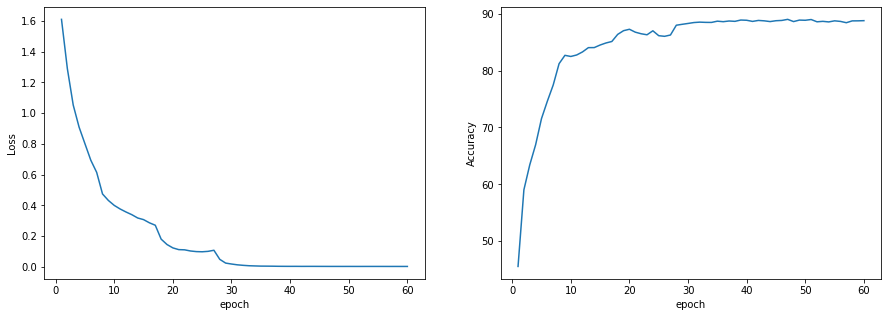

In [23]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(data=loss_df, x="epoch", y="Loss", ax=ax1)
sns.lineplot(data=acc_df, x="epoch", y="Accuracy", ax=ax2)

In [24]:
correct = 0
total = 0

with torch.no_grad():
    for data in val_dl:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy: {0:0.5f}%'.format(100 * correct / total))

Accuracy: 88.66000%
